# Error Mitigation in Quantum Measurement <br> through Fuzzy C-Means Clustering
### by Giovanni Acampora and Autilia Vitiello
### Accepted to FUZZ-IEEE 2021

#### Abstract
Recently, quantum computing is entered in the so-called Noisy Intermediate-Scale Quantum (NISQ) era, where devices characterized by a few number of qubits are potentially able to overcome classical computers in performing specific tasks, but noise in quantum operators still limits the size of quantum circuits that can be run in a reliable way. Consequently, there is a strong need for error mitigation approaches aimed at increasing reliability in quantum computation and making this paradigm really useful and productive in real world applications. In this paper, a fuzzy method, such as Fuzzy C-Means (FCM) clustering, has been used, for the very first time, to support the identification of matrices for error mitigation in quantum measurement. As shown in experiments, mitigation matrices identified with the support of FCM are able to strongly reduce error in quantum outcome.

#### Importing Modules
In order to run our algorithm, it is necessary to import the required Python modules.

In [1]:
from qiskit import Aer
from qiskit.quantum_info import hellinger_fidelity
import os
from sympy import Matrix

import FuzzyQMEM.quantum_utils as qu
from FuzzyQMEM.CreateFuzzyClusteringData import createData
from FuzzyQMEM.CreateFuzzyCalibrationMatrix import createFuzzyBasedCalibrationMatrix
import FuzzyQMEM.utils as utils

#### Dataset creation step
This step is performed to collect information about the behavior of a quantum processor by gathering a set of count vectors. In detail, this step  consists of generating $2^{num\_bits}$ datasets (where $num\_bits$ is the size of the quantum  register to be correct). The $i$-th dataset contains a set of count vectors generated as output of *number_instances* quantum experiments running the circuit related to the $i$-th computational basis state. To simulate quantum processors with different measurement errors, we use the QASM simulator equipped with a Pauli noise model with a given probability error (currently, the error probability is set to 0.15). Please, change the value of the variable *error* to set a different error probability (the values considered in the paper are: 0.05, 0.1, 0.15)

In [2]:
error = 0.15
backend = Aer.get_backend('qasm_simulator')
noise_model = qu.get_noise(error)
num_qubits = 2
number_instances = 100
path="Data/"
if not os.path.exists(path):
    os.makedirs(path)
num_runs=1
createData(num_qubits, backend, noise_model, number_instances, num_runs, path)

Number of instances:   0%|          | 0/100 [00:00<?, ?it/s]/Users/autiliavitiello/PyCharmProjects/FuzzyQMEM/venv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/autiliavitiello/PyCharmProjects/FuzzyQMEM/venv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
Number of instances: 100%|██████████| 100/100 [00:01<00:00, 56.77it/s]

Data created!


#### Fuzzy computation of the mitigation matrix
Similar count vectors identify a similar error pattern for the quantum processor.  Therefore, performing clustering procedure on generated datasets allows detecting the different error patterns that affect a quantum processor. Hence, this step consists of applying the Fuzzy C-Means (FCM) algorithm for each one of the $2^{num\_bits}$ datasets created in the previous step. FCM takes in input the dataset to be clustered and the number of clusters $c$ and returns the final fuzzy partition matrix when a number of iterations *num_iterations* has been satisfied. The optimal value for $c$ is computed by executing the FCM algorithm for different values of the number of clusters *list_k* and selecting the value that provides the best result according to the fuzzy partition coefficient. At the end the calibration matrix is computed by considering the count vectors (one for each computational basis states) with the most uncertain membership degrees in order to consider a trade-off between the different error patterns that affect the quantum processor. Finally, the mitigation matrix is computed as the inverse of the calibration matrix. More details can be found in the Section III of the paper.

In [3]:
state_labels = qu.createStateLabels(num_qubits)
num_iterations=10
list_k=[2, 3, 4]
path="Data/"
dict_data={}
objs=[]
for j in range(num_runs):
    for s in state_labels:
        dict_data[s] = utils.load_obj(path + "Alldata_" + str(number_instances) + "_" + s + "_" + str(j))
    measFilter = createFuzzyBasedCalibrationMatrix(state_labels,0, num_iterations, list_k, dict_data, path)
    objs.append(measFilter)
    calibrationMatrix=measFilter.cal_matrix
    print('FCM algorithm is used to compute the Calibration Matrix:')
    display(Matrix(calibrationMatrix))
    print('The inverse of the Calibration Matrix is computed to get the Mitigation Matrix:')
    mitigationMatrix=qu.getMitigationMatrix(calibrationMatrix)
    display(Matrix(mitigationMatrix))

FCM algorithm is used to compute the Calibration Matrix:


Matrix([
[0.724, 0.129, 0.128, 0.019],
[0.142, 0.717, 0.033, 0.108],
[0.114, 0.022, 0.719, 0.145],
[0.034, 0.119,  0.13, 0.717]])

The inverse of the Calibration Matrix is computed to get the Mitigation Matrix:


Matrix([
[  1.47167073397563, -0.265694814667837, -0.259472080738249,  0.053496161430454],
[-0.283767874939008,   1.48161050431475, 0.0223237405240285, -0.220166369899771],
[-0.228432682988576,  0.045506303910012,   1.48379838049795, -0.300872001419388],
[0.0187277837532571, -0.241553480924757, -0.260429935623421,   1.48325563279492]])

#### Test circuit
In order to test the benefits of the generated mitigation matrix, it is possible to use one of the test circuits reported in the paper in Fig. 3. Please, set the variable *circuit_index* to 'a', 'b', 'c', 'd' or 'e' if you want change the test circuit.

In [4]:
circuit_index='a'
qc=qu.getTestCase(circuit_index)
qc.createCircuit()
qc.circuit.draw(output='mpl')

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

#### Running test circuit
This code allows running the test circuit chosen in the previous code and displaying the noisy results of the execution against the ideal one (i.e., the results obtained on an ideal quantum processor without noisy). Please, change the value of the variable *num_shots* to set a different number of shots to run the test circuit.

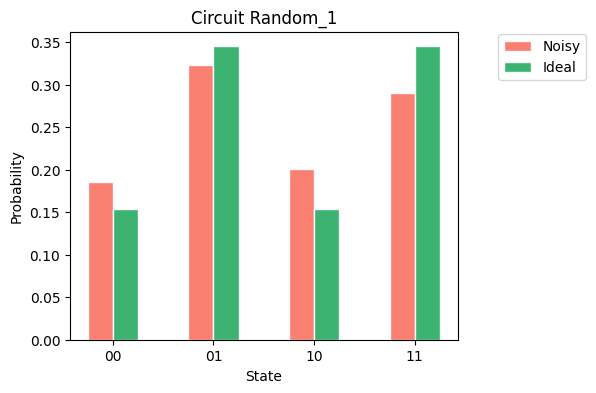

Ideal count vector {'00': 154, '01': 345, '10': 154, '11': 345}
Noisy count vector {'00': 186, '11': 290, '10': 201, '01': 323}


In [5]:
num_shots=1000
results=qu.executeTestCircuit(qc.circuit,backend, noise_model, shots=num_shots)
ideal_results=qu.convertInDict(qc.getOptimalDistribution(num_shots), num_qubits)
qu.plot_results(qc.name,results, ideal_results)
print('Ideal count vector', ideal_results)
print('Noisy count vector', results.get_counts(0))

#### Applying mitigation matrix
This code allows applying the generated mitigation matrix on the noisy results obtained by running the test circuit. As shown by the plot displayed by running this code, the mitigated results are closer to ideal ones than noisy results.

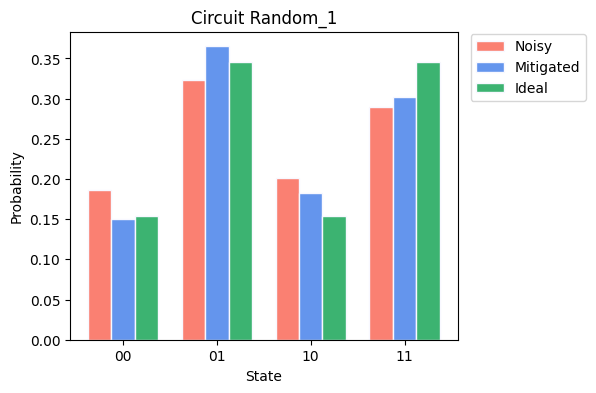

Noisy count vector {'00': 186, '11': 290, '10': 201, '01': 323}
Mitigated count vector {'00': 150, '01': 365, '10': 182, '11': 302}
Ideal count vector {'00': 154, '01': 345, '10': 154, '11': 345}


In [6]:
meas_filter=objs[0]
mitigated_results=qu.round_dict(meas_filter.apply(results).get_counts(0))
qu.plot_results(qc.name,results, ideal_results, mitigated_results)

print('Noisy count vector',results.get_counts(0))
print('Mitigated count vector',mitigated_results)
print('Ideal count vector', ideal_results)

#### Hellinger fidelity
To formally show the improvement achieved by the mitigated results, we use the Hellinger fidelity metric. We use this metric to compute the similarity between a quantum outcome and the ideal one. The higher the Hellinger fidelity and the better is the quantum outcome. 

In [7]:
H_results=hellinger_fidelity(results.get_counts(0), ideal_results)
H_mitigated=hellinger_fidelity(mitigated_results, ideal_results)
print("The Hellinger fidelity between the noisy results and the ideal one is", H_results)
print("The Hellinger fidelity between the mitigated results and the ideal one is", H_mitigated)

The Hellinger fidelity between the noisy results and the ideal one is 0.9926242568794981
The Hellinger fidelity between the mitigated results and the ideal one is 0.9970907558195723
